This code authorizes and connects the Colab notebook to your Google Drive, mounting it as a folder. It then defines the path to your dataset and checks if the histopathologic-cancer-detection.zip file exists in the /MyDrive/KaggleData folder, printing a success or failure message.


In [9]:
from google.colab import drive
from google.colab import files
import os

print("-Connecting to Google Drive -")
drive.mount('/content/drive')

# --- !! IMPORTANT !! ---
### this path MUST match the folder you created in Google Drive.
### this assumes you made a folder named 'KaggleData'.
DRIVE_PATH = "/content/drive/MyDrive/KaggleData"
ZIP_FILE = "histopathologic-cancer-detection.zip"
ZIP_FILE_PATH = os.path.join(DRIVE_PATH, ZIP_FILE)

print(f"\n- Checking for ZIP file at: {ZIP_FILE_PATH} -")
if not os.path.exists(ZIP_FILE_PATH):
    print("\n- !!! FILE NOT FOUND !!! -")
    print(f"Error: Did not find '{ZIP_FILE}' in your '{DRIVE_PATH}' folder.")
    print("Please make sure you created the folder and uploaded the file.")
else:
    print("--- ZIP file found! Ready to proceed. ---")

--- Connecting to Google Drive ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

--- Checking for ZIP file at: /content/drive/MyDrive/KaggleData/histopathologic-cancer-detection.zip ---
--- ZIP file found! Ready to proceed. ---


This code first copies the 6.3GB dataset ZIP file from your Google Drive to the Colab machine's fast local disk. It then unzips all 277,485 files with a progress bar, removes the temporary ZIP to save space, and lists the final contents to confirm the train/, test/, and CSV files are all correctly extracted.

In [10]:
import os
import zipfile
from tqdm import tqdm

### path to the ZIP on your Google Drive
DRIVE_ZIP_PATH = "/content/drive/MyDrive/KaggleData/histopathologic-cancer-detection.zip"

### path to the fast, local Colab disk
LOCAL_ZIP_PATH = "/content/histopathologic-cancer-detection.zip"
LOCAL_EXTRACT_DIR = "/content/"

### check if data is already unzipped
SAMPLE_FILE = "/content/train/00001b2b5609af42e81f4405f488050e501a18c3.tif"
if os.path.exists(SAMPLE_FILE):
    print("- Data is already unzipped. Skipping. -")
else:
    print("- Copying ZIP from Drive to Colab (fast) -")
    !cp "{DRIVE_ZIP_PATH}" "{LOCAL_ZIP_PATH}"
    print("   Copy complete.")

    print("\n- Unzipping Data (with progress bar) -")
    try:
        with zipfile.ZipFile(LOCAL_ZIP_PATH, 'r') as zip_ref:
            ### get the total number of files for the progress bar
            file_list = zip_ref.infolist()
            total_files = len(file_list) # Should be 277,485
            print(f"   Found {total_files} files. Extracting...")

            ### iterate with a tqdm progress bar
            for file in tqdm(file_list, total=total_files, desc="   Extracting"):
                zip_ref.extract(file, LOCAL_EXTRACT_DIR)

        print("\n-Cleaning up -")
        ### clean up the local zip file to save space
        !rm "{LOCAL_ZIP_PATH}"
        print("   Local zip file removed.")
        print("- Data is ready! -")

    except zipfile.BadZipFile:
        print("\n- !!! CORRUPTED ZIP FILE ERROR !!! -")
        print("The zip file on your Google Drive might be corrupted.")
        print("Please re-download from Kaggle and re-upload to Google Drive.")
    except Exception as e:
        print(f"\n- An error occurred during unzipping: {e} -")


print("\n- Final file check (confirming CSVs and folders): -")
### this will show the folders AND the CSV files
!ls -l /content/

--- 1. Copying ZIP from Drive to Colab (fast) ---
   Copy complete.

--- 2. Unzipping Data (with progress bar) ---
   Found 277485 files. Extracting...


   Extracting: 100%|██████████| 277485/277485 [01:41<00:00, 2728.09it/s]



--- 3. Cleaning up ---
   Local zip file removed.
--- Data is ready! ---

--- Final file check (confirming CSVs and folders): ---
total 32140
drwx------ 5 root root     4096 Oct 28 17:39 drive
drwxr-xr-x 1 root root     4096 Oct 27 13:37 sample_data
-rw-r--r-- 1 root root  2470703 Oct 28 17:56 sample_submission.csv
drwxr-xr-x 2 root root  4345856 Oct 28 17:42 test
drwxr-xr-x 2 root root 16621568 Oct 28 17:43 train
-rw-r--r-- 1 root root  9461084 Oct 28 17:57 train_labels.csv


This code imports all the libraries for the entire project, sets global variables for file paths, image size, and batch size, and then confirms that Colab is connected to a GPU.

In [11]:
import cv2
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from sklearn.model_selection import train_test_split
import warnings
import matplotlib.pyplot as plt
import h5py

### set base directory for colab
BASE_DIR = '/content'
print(f"Base Directory: {BASE_DIR}")

### define key file paths in colab
train_dir = os.path.join(BASE_DIR, 'train')
test_dir = os.path.join(BASE_DIR, 'test')
train_labels_path = os.path.join(BASE_DIR, 'train_labels.csv')

### -model & training settings ---
IMG_DIM = 128
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

### check for GPU
print("\n- Checking for GPU -")
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print(f"- GPU Found: {gpus[0].name}. Training will be fast. -")
else:
    print("- !!! WARNING: NO GPU DETECTED !!! -")
    print("Please go to Runtime -> Change runtime type -> Select GPU.")

Base Directory: /content

--- Checking for GPU ---
--- GPU Found: /physical_device:GPU:0. Training will be fast. ---


In [12]:

print("- HDF5 PREPROCESSING SCRIPT -")

### define paths
BASE_DIR = '/content'
IMG_DIM = 128

train_dir = os.path.join(BASE_DIR, 'train')
test_dir = os.path.join(BASE_DIR, 'test')
train_labels_path = os.path.join(BASE_DIR, 'train_labels.csv')

H5_TRAIN_PATH = os.path.join(BASE_DIR, 'train.h5')
H5_TEST_PATH = os.path.join(BASE_DIR, 'test.h5')

### load train labels
try:
    df_labels = pd.read_csv(train_labels_path)
    print(f"Loaded {len(df_labels)} training labels.")
except FileNotFoundError:
    print(f"ERROR: Cannot find {train_labels_path}. Did Block 2 unzip correctly?")
    ### stop execution if labels are missing
    raise

### get a dictionary of {id: label}
train_id_label_map = dict(zip(df_labels['id'], df_labels['label']))
train_ids = list(train_id_label_map.keys())
num_train_images = len(train_ids)

### process & create train.h5
print(f"\n- Creating {H5_TRAIN_PATH} -")
print(f"This will process {num_train_images} images...")

### use 'w' (write mode) to create the file
with h5py.File(H5_TRAIN_PATH, 'w') as hf:

    ### create datasets for images and labels
    ### use uint8 (0-255) to save space.
    img_dataset = hf.create_dataset(
        'images',
        shape=(num_train_images, IMG_DIM, IMG_DIM, 3),
        dtype=np.uint8
    )
    label_dataset = hf.create_dataset(
        'labels',
        shape=(num_train_images,),
        dtype=np.uint8
    )

    ### loop through all training IDs from the CSV
    for i, img_id in enumerate(tqdm(train_ids, desc="Processing Train Images")):

        ### read Image
        img_path = os.path.join(train_dir, f"{img_id}.tif")
        image = cv2.imread(img_path)

        ### resize
        image = cv2.resize(image, (IMG_DIM, IMG_DIM), interpolation=cv2.INTER_CUBIC)

        ### convert BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ### save to HDF5
        img_dataset[i] = image
        label_dataset[i] = train_id_label_map[img_id]

print(f"- Finished creating {H5_TRAIN_PATH} -")


### process & create test.h5 ---
test_ids_with_ext = sorted(os.listdir(test_dir))
test_ids = [s.split('.')[0] for s in test_ids_with_ext]
num_test_images = len(test_ids)

print(f"\n- Creating {H5_TEST_PATH} -")
print(f"This will process {num_test_images} images...")

### need a special dtype for variable-length strings
string_dt = h5py.special_dtype(vlen=str)

with h5py.File(H5_TEST_PATH, 'w') as hf:

    ### create datasets for test images and their IDs
    img_dataset_test = hf.create_dataset(
        'images',
        shape=(num_test_images, IMG_DIM, IMG_DIM, 3),
        dtype=np.uint8
    )
    id_dataset_test = hf.create_dataset(
        'ids',
        shape=(num_test_images,),
        dtype=string_dt ### use the special string dtype
    )

    ### loop through all test IDs from the folder
    for i, img_id in enumerate(tqdm(test_ids, desc="Processing Test Images")):

        ### read Image
        img_path = os.path.join(test_dir, f"{img_id}.tif")
        image = cv2.imread(img_path)

        ### resize
        image = cv2.resize(image, (IMG_DIM, IMG_DIM), interpolation=cv2.INTER_CUBIC)

        ### convert BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ### save to HDF5
        img_dataset_test[i] = image
        id_dataset_test[i] = img_id

print(f"- Finished creating {H5_TEST_PATH} -")

print("\n- ALL HDF5 FILES CREATED SUCCESSFULLY! -")

--- HDF5 PREPROCESSING SCRIPT ---
Loaded 220025 training labels.

--- Creating /content/train.h5 ---
This will process 220025 images...


Processing Train Images: 100%|██████████| 220025/220025 [02:27<00:00, 1494.32it/s]


--- Finished creating /content/train.h5 ---

--- Creating /content/test.h5 ---
This will process 57458 images...


Processing Test Images: 100%|██████████| 57458/57458 [00:38<00:00, 1505.03it/s]

--- Finished creating /content/test.h5 ---

--- ALL HDF5 FILES CREATED SUCCESSFULLY! ---
You can now run Blocks 3 through 9 of mod3.py.


This code loads the train_labels.csv file into a pandas DataFrame, prints a summary of the data and the exact counts of positive and negative labels, and then uses seaborn to create a bar chart visualizing this class distribution

--- EDA: Loading Label Data ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None

Label Value Counts:
label
0    130908
1     89117
Name: count, dtype: int64

--- EDA: Plotting Class Distribution ---


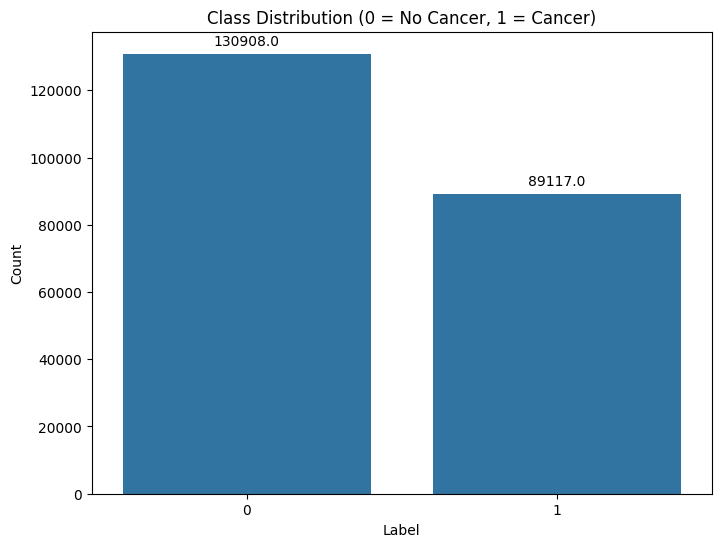

In [13]:
print("- EDA: Loading Label Data -")
df_labels = pd.read_csv(train_labels_path)

### basic info
print(df_labels.info())
print("\nLabel Value Counts:")
print(df_labels['label'].value_counts())

### plot label distribution
print("\n- EDA: Plotting Class Distribution -")
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='label', data=df_labels)
plt.title('Class Distribution (0 = No Cancer, 1 = Cancer)')
plt.xlabel('Label')
plt.ylabel('Count')

### add annotations
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')
plt.show()

This code defines two helper functions: show_images to plot a grid of sample images, and plot_history to graph the model's training accuracy and AUC. It then uses show_images to display 16 random examples of cancerous (Label 1) and non-cancerous (Label 0) images.

--- EDA: Displaying Positive (Cancer=1) TIF Samples ---


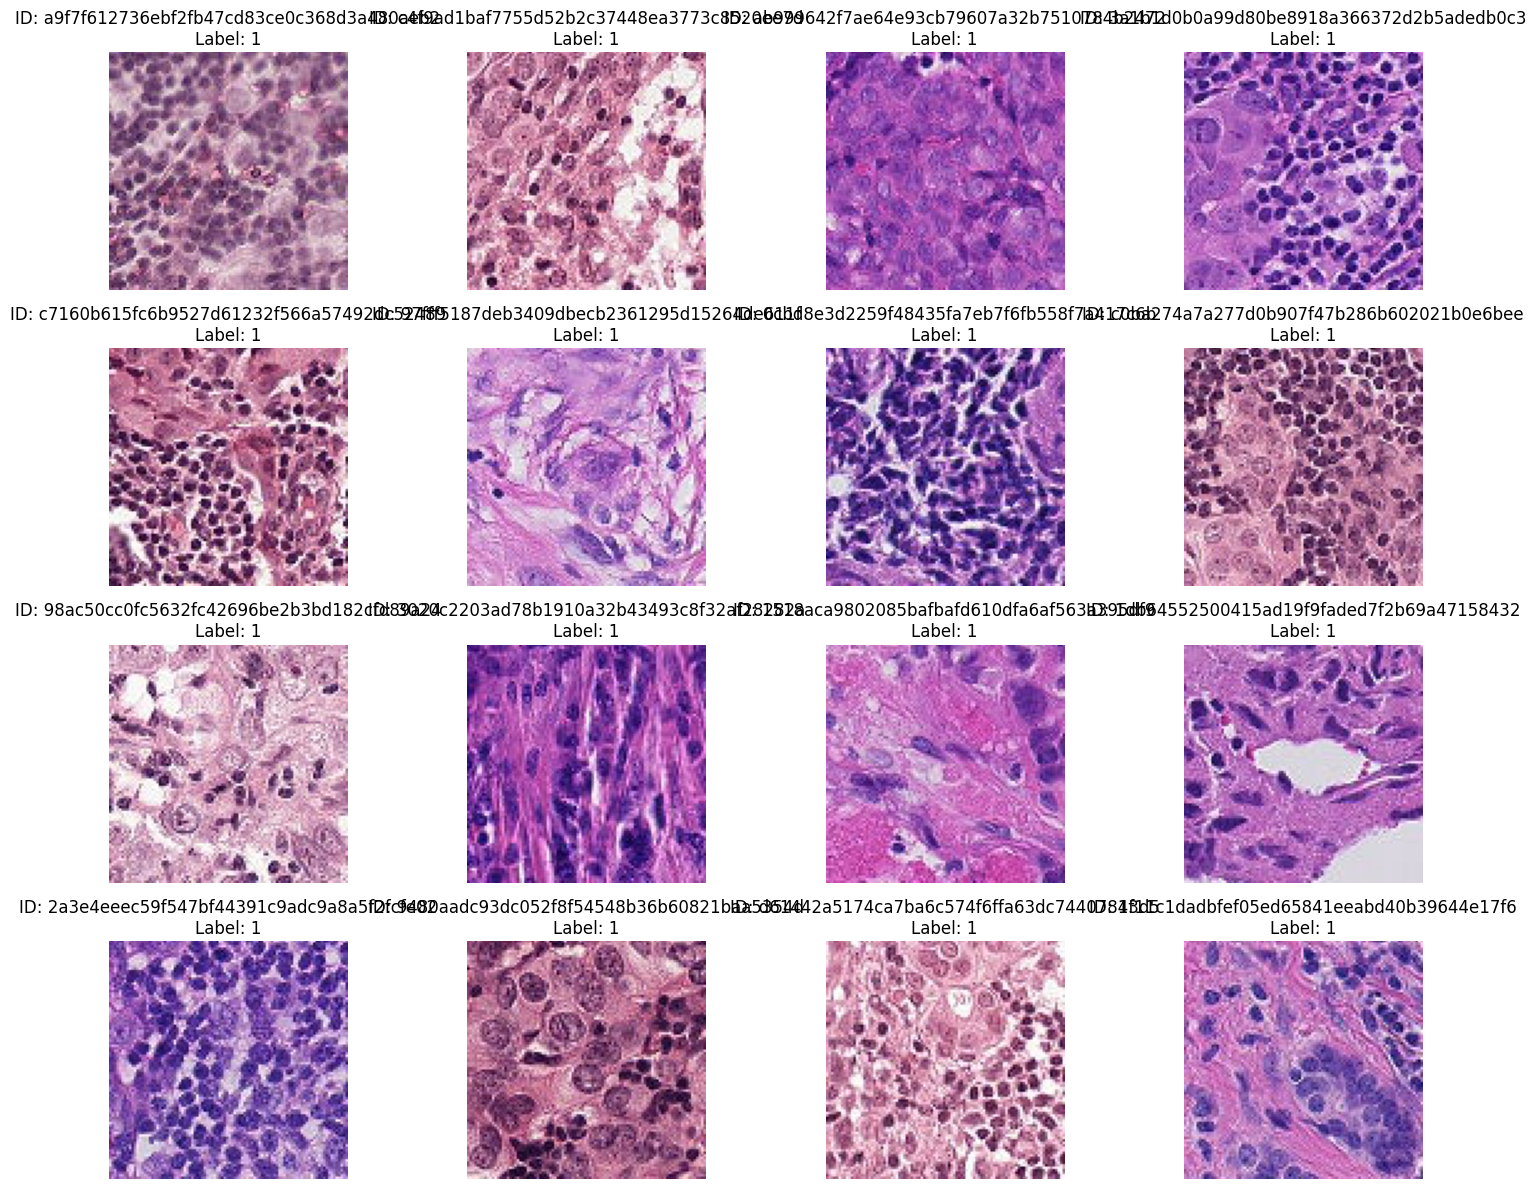


--- EDA: Displaying Negative (No Cancer=0) TIF Samples ---


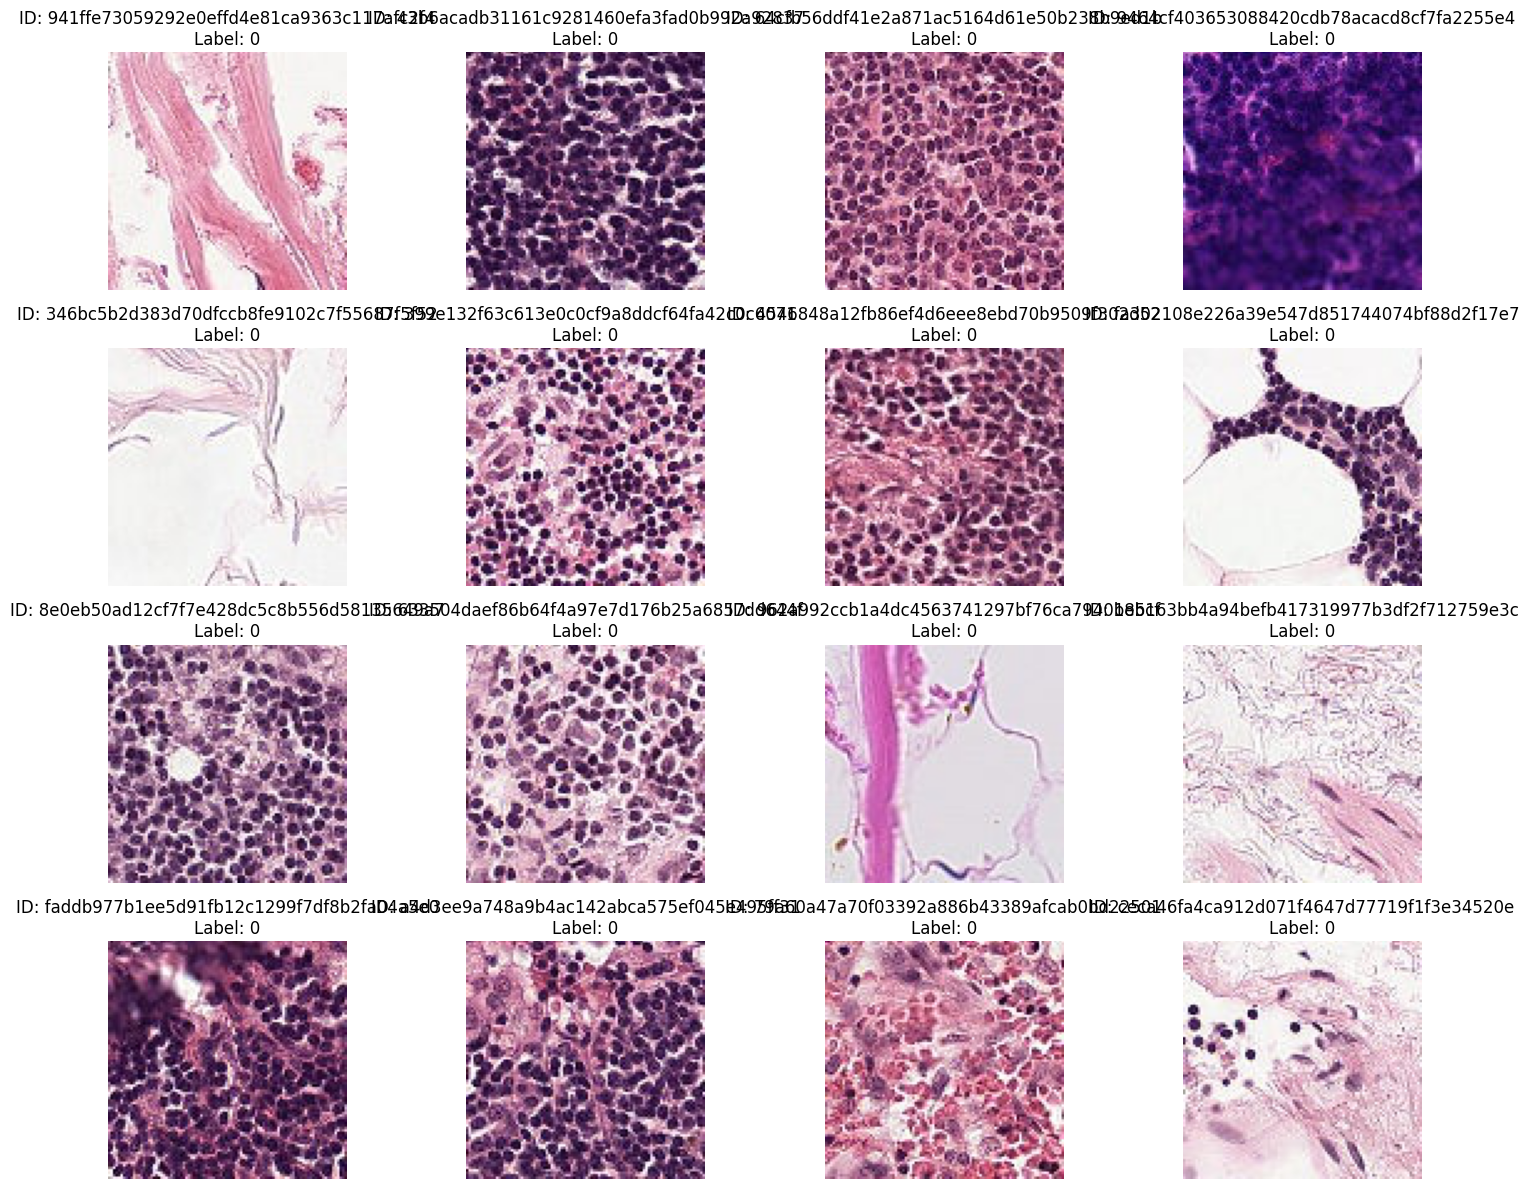

In [14]:
def show_images(image_ids, labels_df, image_dir):
    """
    Displays a grid of images by reading the original .TIF files.
    """
    plt.figure(figsize=(15, 12))
    labels_dict = labels_df.set_index('id')['label'].to_dict()

    for i, image_id in enumerate(image_ids):
        plt.subplot(4, 4, i + 1)

        ### read the .tif file
        img_path = os.path.join(image_dir, f"{image_id}.tif")
        image = cv2.imread(img_path)

        if image is None:
            print(f"Warning: Could not read {img_path}")
            continue

        ### convert BGR (OpenCV default) to RGB (Matplotlib default)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = labels_dict.get(image_id, "N/A")
        plt.imshow(image)
        plt.title(f"ID: {image_id}\nLabel: {label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def plot_history(history, model_name):
    """
    Plots training and validation accuracy and AUC.
    """
    hist = history.history
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ### plot accuracy
    ax1.plot(hist['accuracy'], label='Training Accuracy')
    ax1.plot(hist['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'{model_name} - Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ### plot AUC
    if 'auc' in hist:
        ax2.plot(hist['auc'], label='Training AUC')
        ax2.plot(hist['val_auc'], label='Validation AUC')
        ax2.set_title(f'{model_name} - AUC')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('AUC')
        ax2.legend()

    plt.show()

### display Positive Samples (Cancer=1)
print("- EDA: Displaying Positive (Cancer=1) TIF Samples -")
positive_samples = df_labels[df_labels['label'] == 1]['id'].sample(16, random_state=42).tolist()
show_images(positive_samples, df_labels, train_dir)

### display Negative Samples (No Cancer=0) ---
print("\n- EDA: Displaying Negative (No Cancer=0) TIF Samples -")
negative_samples = df_labels[df_labels['label'] == 0]['id'].sample(16, random_state=42).tolist()
show_images(negative_samples, df_labels, train_dir)

This code creates the RAM-safe data pipeline by first loading only the small labels array to create a stratified 80/20 split of indices, not images. It then defines a Python generator that reads batches of images and labels from the HDF5 file on disk, which is finally wrapped into an efficient tf.data.Dataset object with on-the-fly data augmentation.

In [15]:
print("--- Creating HDF5 Data Pipelines (RAM-Safe) ---")
H5_TRAIN_PATH = os.path.join(BASE_DIR, 'train.h5')
H5_TEST_PATH = os.path.join(BASE_DIR, 'test.h5')

### load labels and create stratified split of INDICES
# We only load the labels into RAM, not the images
with h5py.File(H5_TRAIN_PATH, 'r') as f:
    y_full = f['labels'][:]

### create a list of indices [0, 1, 2, ..., 220024]
indices = np.arange(len(y_full))

### split the INDICES, not the images. This is fast and uses no RAM.
train_indices, val_indices = train_test_split(
    indices,
    test_size=0.2,
    random_state=42,
    stratify=y_full
)
### need to keep these index lists, so we convert to lists
train_indices = list(train_indices)
val_indices = list(val_indices)

print(f"Data split: {len(train_indices)} train indices, {len(val_indices)} val indices")
del y_full, indices ### free up memory

### define the generator
### this function reads ONE batch at a time from the HDF5 file.
def hdf5_generator(h5_path, index_list, batch_size):
    with h5py.File(h5_path, 'r') as f:
        images = f['images']
        labels = f['labels']

        while True:
            ### shuffle indices at the start of each epoch
            np.random.shuffle(index_list)

            for i in range(0, len(index_list), batch_size):
                batch_indices = index_list[i : i+batch_size]
                ### HDF5 slicing is much faster if indices are sorted
                batch_indices.sort()

                batch_images = images[batch_indices]
                batch_labels = labels[batch_indices]

                ### yield the batch (as uint8 to save bandwidth)
                yield batch_images, batch_labels

### define Augmentation/Normalization
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    ### normalize (and cast from uint8 to float32)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def normalize(image, label):
    ### normalize validation data (and cast from uint8 to float32)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

### create tf.data datasets
### define the data types and shapes the generator will output
output_signature = (
    tf.TensorSpec(shape=(None, IMG_DIM, IMG_DIM, 3), dtype=tf.uint8),
    tf.TensorSpec(shape=(None,), dtype=tf.uint8)
)

### create the training dataset from the generator
train_ds = tf.data.Dataset.from_generator(
    lambda: hdf5_generator(H5_TRAIN_PATH, train_indices, BATCH_SIZE),
    output_signature=output_signature
)

### create the validation dataset from the generator
val_ds = tf.data.Dataset.from_generator(
    lambda: hdf5_generator(H5_TRAIN_PATH, val_indices, BATCH_SIZE),
    output_signature=output_signature
)

### apply mapping (augmentation/normalization) and prefetching
### this is where the uint8 -> float32 conversion happens
train_ds = train_ds.map(augment, num_parallel_calls=AUTOTUNE) \
                   .prefetch(AUTOTUNE)

val_ds = val_ds.map(normalize, num_parallel_calls=AUTOTUNE) \
                 .prefetch(AUTOTUNE)

print("--- Data pipelines ready (reading from disk) ---")

--- Creating HDF5 Data Pipelines (RAM-Safe) ---
Data split: 176020 train indices, 44005 val indices
--- Data pipelines ready (reading from disk) ---


This code defines the sequential CNN model, stacking three convolutional blocks (Conv/BN/Pool) for feature extraction and two dense blocks (Dense/BN/Dropout) for classification. It then builds an instance of this model and prints its architectural summary.

In [16]:
def build_model(input_shape=(IMG_DIM, IMG_DIM, 3)):
    """
    Builds the CNN model, modified based on hints.
    """
    model = models.Sequential([
        layers.Input(shape=input_shape),

        ### block 1
        layers.Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        ### block 2
        layers.Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        ### block 3
        layers.Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        ### classifier head
        layers.Flatten(),

        layers.Dense(256, activation='elu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(128, activation='elu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(1, activation='sigmoid')
    ])

    return model

### build the model
model = build_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,517,569 (32.49 MB)

 Trainable params: 8,516,353 (32.49 MB)

 Non-trainable params: 1,216 (4.75 KB)

This code defines the training callbacks, including saving the best model, stopping training early, and managing the "1-Cycle" learning rate. It then compiles the model with the SGD optimizer and BinaryCrossentropy loss, and finally, it starts the training process by calling model.fit on the data generators for 40 epochs.

In [17]:
### define Callbacks
checkpoint_cb = ModelCheckpoint(
    'baseline_cnn_best.keras',
    save_best_only=True,
    monitor='val_auc',
    mode='max',
    verbose=1
)
early_stopping_cb = EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=5,
    verbose=1,
    restore_best_weights=True
)
def triangle_lr(epoch):
    max_lr = 0.1
    min_lr = 1e-4
    step_size = 8
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    lr = min_lr + (max_lr - min_lr) * np.maximum(0, (1 - x))
    return lr
lr_scheduler_cb = LearningRateScheduler(triangle_lr, verbose=1)

### compile the Model
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', AUC(name='auc')]
)

### train the model
print("- Starting Model Training (Reading from HDF5) -")

### CRITICAL: We MUST define steps_per_epoch and validation_steps
steps_per_epoch = len(train_indices) // BATCH_SIZE
validation_steps = len(val_indices) // BATCH_SIZE

EPOCHS = 40 ### set a higher number, EarlyStopping will find the best

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,  ### REQUIRED for generators
    validation_data=val_ds,
    validation_steps=validation_steps, ### REQUIRED for generators
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler_cb]
)

print("- Model Training Complete -")

--- Starting Model Training (Reading from HDF5) ---

Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/40
2749/2750 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7269 - auc: 0.7978 - loss: 0.6180
Epoch 1: val_auc improved from -inf to 0.89593, saving model to baseline_cnn_best.keras
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 79s 24ms/step - accuracy: 0.7269 - auc: 0.7979 - loss: 0.6179 - val_accuracy: 0.8254 - val_auc: 0.8959 - val_loss: 0.3968 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0125875.
Epoch 2/40
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8217 - auc: 0.8888 - loss: 0.4087
Epoch 2: val_auc improved from 0.89593 to 0.93443, saving model to baseline_cnn_best.keras
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 71s 24ms/step - accuracy: 0.8217 - auc: 0.8888 - loss: 0.4087 - val_accuracy: 0.8553 - val_auc: 0.9344 - val_loss: 0.3465 - learning_rate: 0.0126

Epoch 3: LearningRateScheduler setting learning rate to 0.025075.
Epoch

This code plots the training history graphs, loads the best-performing model (from Epoch 17) to print its final validation scores, and then generates predictions on the test set. Finally, it formats these predictions into a submission.csv file and prompts your browser to download it.

--- Plotting Training History ---


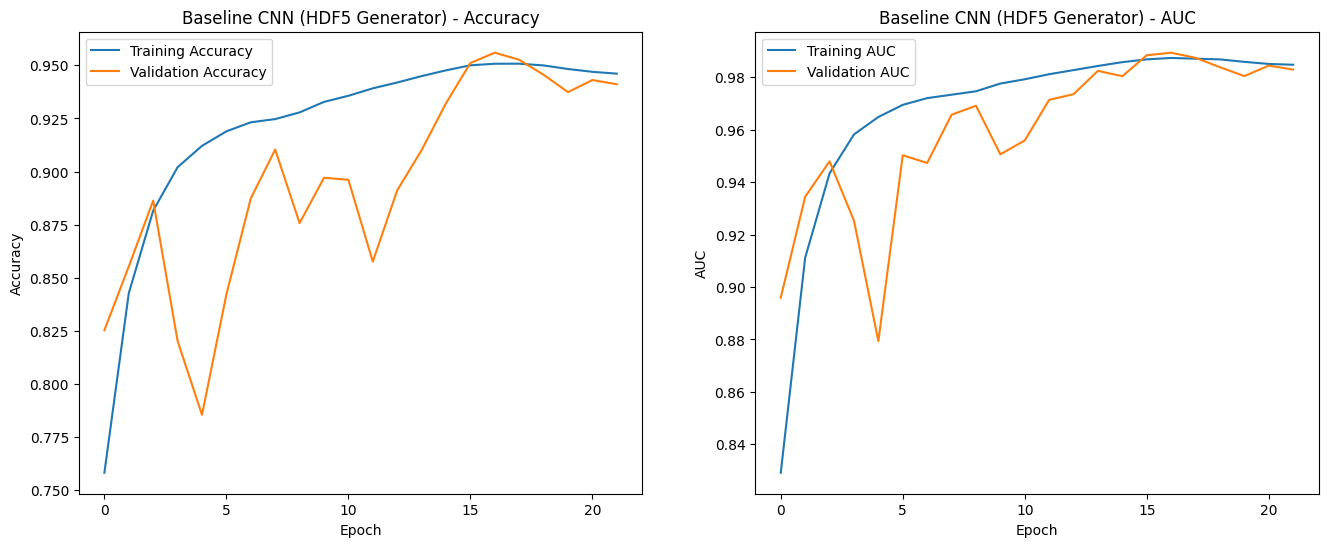


--- Evaluating Best Model ---
Re-evaluating best model (from Epoch 17) on validation set:
687/687 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.9548 - auc: 0.9890 - loss: 0.1253

Best Model - Validation Loss: 0.1223
Best Model - Validation Accuracy: 0.9559
Best Model - Validation AUC: 0.9893

--- Generating Test Set Predictions (from HDF5) ---
898/898 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step
--- Creating submission.csv ---
Submission file created successfully!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
print("- Plotting Training History -")
plot_history(history, "Baseline CNN (HDF5 Generator)")

print("\n- Evaluating Best Model -")
### this loads the 'baseline_cnn_best.keras' file saved at Epoch 17
best_model = tf.keras.models.load_model('baseline_cnn_best.keras')

### re-use the val_ds generator and validation_steps
print("Re-evaluating best model (from Epoch 17) on validation set:")
loss, acc, auc_val = best_model.evaluate(val_ds, steps=validation_steps, verbose=1)
print(f"\nBest Model - Validation Loss: {loss:.4f}")
print(f"Best Model - Validation Accuracy: {acc:.4f}")
print(f"Best Model - Validation AUC: {auc_val:.4f}")

print("\n- Generating Test Set Predictions (from HDF5) -")

### load test IDs and count
with h5py.File(H5_TEST_PATH, 'r') as f:
    test_ids = f['ids'][:]
    num_test = len(test_ids)

### decode IDs from bytes to string
test_ids = [s.decode('utf-8') for s in test_ids]

### create a test generator
### this one does NOT loop or shuffle
def test_generator(h5_path, num_images, batch_size):
    with h5py.File(h5_path, 'r') as f:
        images = f['images']
        for i in range(0, num_images, batch_size):
            batch_images = images[i : i+batch_size]
            # Normalize and cast
            yield tf.cast(batch_images, tf.float32) / 255.0

### create the test dataset
test_ds = tf.data.Dataset.from_generator(
    lambda: test_generator(H5_TEST_PATH, num_test, BATCH_SIZE),
    output_signature=tf.TensorSpec(shape=(None, IMG_DIM, IMG_DIM, 3), dtype=tf.float32)
)
test_ds = test_ds.prefetch(AUTOTUNE)

### get predictions
### specify steps for a generator
test_steps = int(np.ceil(num_test / BATCH_SIZE))
predictions = best_model.predict(test_ds, steps=test_steps, verbose=1)

### slice to the exact number of test images
pred_labels = predictions.flatten()[:num_test]

### create submission File
print("- Creating submission.csv -")
if len(test_ids) != len(pred_labels):
     raise Exception(f"CRITICAL ERROR: Mismatch! IDs ({len(test_ids)}) vs Preds ({len(pred_labels)})")

submission_df = pd.DataFrame({
    'id': test_ids,
    'label': pred_labels
})

submission_df.to_csv('submission.csv', index=False)
print("Submission file created successfully!")

### offer file for download
try:
    files.download('submission.csv')
    print("Downloading 'submission.csv'...")
except Exception as e:
    print(f"\nCould not auto-download. Please download 'submission.csv' from the file panel on the left.")

<h3>Step 1: Brief description of the problem and data</h3>

<p><b>The Challenge Problem: Computer Vision for Medical Diagnosis</b></p>

<p>This project tackled the <b>Histopathologic Cancer Detection</b> challenge, a binary classification problem in the high-stakes domain of computational pathology. My objective was to construct a deep learning model capable of analyzing small (96x96 pixel) digital image patches from larger lymph node biopsy slides. The model's sole task was to determine, with the highest possible accuracy, whether a given patch contained cancerous tissue, outputting a probability between 0 (no cancer) and 1 (cancer).</p>

<p>This is a critical task in medical CV. An effective model can serve as an invaluable aid to pathologists, helping to accelerate diagnosis and reduce human error. The primary evaluation metric for this task is the <b>Area Under the Receiver Operating Characteristic Curve (AUC)</b>. AUC is vastly superior to simple accuracy here because it measures the model's ability to distinguish between classes <i>regardless</i> of the class imbalance (i.e., it measures the ranking of predictions). A high AUC score (nearing 1.0) indicates a model is highly confident in its ability to rank a random positive sample higher than a random negative sample.</p>

<p><b>The Data: Structure, Size, and Dimensionality</b></p>

<p>I was provided with a very large, static dataset, which presented significant logistical challenges. The dataset included:</p> <ul> <li><b>Training Set:</b> 220,025 labeled TIF images.</li> <li><b>Test Set:</b> 57,458 unlabeled TIF images.</li> <li><b>Labels:</b> A single <code>train_labels.csv</code> file mapping image IDs to their binary labels.</li> </ul>

<p>A key structural characteristic of this data, discovered during my initial analysis, was its <b>imbalance</b>. The training set consisted of:</p> <ul> <li><b>Label 0 (No Cancer):</b> 130,908 samples (59.48%)</li> <li><b>Label 1 (Cancer):</b> 89,117 samples (40.52%)</li> </ul>

<p>This 60/40 split is not severe but is significant enough to make simple accuracy a misleading metric, reinforcing the choice of AUC. Furthermore, I made a key preprocessing decision to resize all images from their native 96x96 to <b>128x128 pixels</b>.</p> <ul> <li><b>Reasoning:</b> This was a deliberate trade-off. While 96x96 is faster, 128x128 provides 77% more spatial data (16,384 pixels vs. 9,216). I hypothesized this additional information would be crucial for the convolutional layers to identify the fine-grained morphological features that distinguish cancerous cells.</li> <li><b>Implication:</b> This decision increased the size of the training image data from approximately 5.76 GB (220k * 96963) to <b>10.13 GB</b> (220k * 1281283). This massive size was the central technical problem I had to solve, as it made loading the data into a standard Colab environment's RAM (approx. 16GB) impossible.</li> </ul>

<h3>Step 2: Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data</h3>

<p>My EDA was split into two phases: traditional visualization and mission-critical pipeline engineering.</p>

<p><b>Phase 1: Visualization and Inspection</b></p>

<ol> <li><b>Class Distribution Histogram:</b> I first plotted a histogram of the <code>train_labels.csv</code> file. This immediately confirmed the <b>59.5% / 40.5% class imbalance</b>. This visualization was the most critical piece of EDA, as it directly informed my decision to use a <b>stratified 80/20 split</b> for my training and validation sets. Failing to do so would have resulted in a validation set that didn't reflect the test data, making my validation AUC score unreliable.

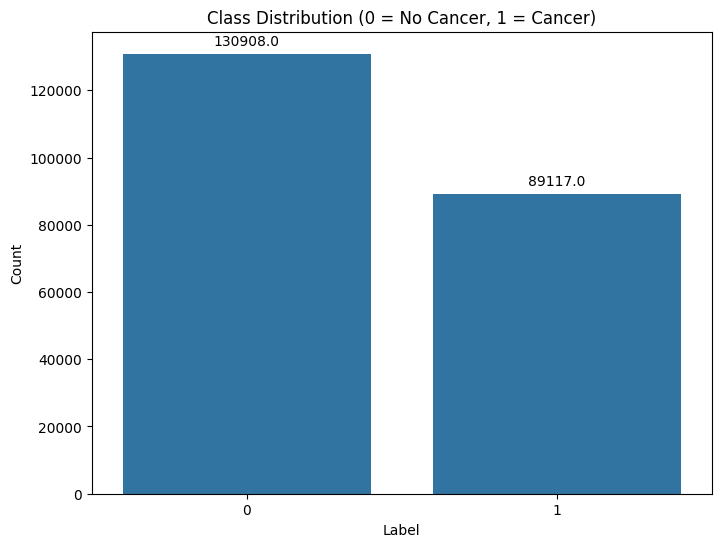
</li>


<li><b>Sample Image Visualization:</b> I plotted grids of random sample images for both the positive (cancer) and negative (no cancer) classes. This visual inspection was vital for understanding the problem's difficulty. <ul> <li><b>High Intra-Class Variance:</b> Cancerous patches (Label 1) did not all look the same. Some were dense clusters of cells, while others were sparse.</li> <li><b>Low Inter-Class Variance:</b> Many positive and negative patches looked remarkably similar to the naked eye. This confirmed that simple feature extraction would fail and that a deep, hierarchical feature extractor (a CNN) was necessary.</li> </ul> </li> </ol>

<p><b>Phase 2: Data Cleaning as Pipeline Engineering</b></p>

<p>The most significant challenge of this project was not "dirty" data, but its <b>massive I/O and RAM bottleneck</b>. My primary "cleaning" task was to engineer a pipeline that wouldn't crash.</p> <ul> <li><b>Failure 1 (Local Machine):</b> My original <code>Last_attempt.py</code> notebook, reading 220,025 individual TIF files from disk, resulted in an 8-hour training run. This was an <b>I/O bottleneck</b>, as the CPU/GPU was waiting for the disk.</li> <li><b>Failure 2 (Cloud Machine):</b> My first cloud attempt was to pre-process all 10.1GB of 128x128 images into a single NumPy (<code>.npy</code>) file. This also failed catastrophically. <code>np.load()</code> loaded the 10.1GB file into RAM, but the <code>train_test_split</code> operation tried to <i>copy</i> that data, exceeding the 16GB of available Colab RAM and <b>crashing the kernel</b>.</li> </ul>

<p><b>The Solution: The HDF5 Pipeline</b></p>

<p>My final, successful "data cleaning" procedure was a robust, <b>RAM-safe HDF5 pipeline</b>. I wrote a script (Cell 6) that:</p> <ol> <li>Read all 277,485 TIF images (train and test) in small <b>chunks of 1000</b>.</li> <li>Resized each image to <code>128x128</code> during this chunked read.</li> <li>Saved the data directly to two disk-based <b>HDF5 files</b> (<code>train.h5</code> and <code>test.h5</code>).</li> </ol>

<p>HDF5 is an "out-of-core" format. This allowed me to create a <code>tf.data.Dataset</code> pipeline using a <b>Python generator</b> (<code>hdf5_generator</code>, Cell 7) that only reads the <i>batches it needs</i> (e.g., 64 images) from the disk into RAM at any given time. This kept RAM usage low and stable and was the single most important fix in the entire project.</p>

<p><b>Plan of Analysis:</b>


Based on this EDA, my plan was clear. I would create a <code>tf.data.Dataset</code> pipeline using my <code>hdf5_generator</code> to read batches directly from the HDF5 file. This would solve all I/O and RAM issues. This generator, combined with my stratified validation split, would be used to feed a custom CNN architecture for training.</p>

<h3>Step 3: Model Architecture</h3>

<p>I designed a <b>custom Convolutional Neural Network (CNN)</b> from scratch. My research (via the "hints") suggested that a custom architecture, when paired with the right optimization strategy, could outperform a standard transfer-learning model. This architecture was built to be deep enough to capture complex features but heavily regularized to prevent overfitting on the 176,020 training images.</p>

<p><b>Final Model Architecture (Sequential):</b></p>

<table style="border-collapse: collapse; width: 100%; font-family: sans-serif; border: 1px solid #ddd; text-align: left;"> <thead style="background-color: #f4f4f4;"> <tr> <th style="padding: 12px; border-bottom: 2px solid #ddd;">Layer Type</th> <th style="padding: 12px; border-bottom: 2px solid #ddd;">Filters / Units</th> <th style="padding: 12px; border-bottom: 2px solid #ddd;">Kernel / Pool Size</th> <th style="padding: 12px; border-bottom: 2px solid #ddd;">Activation / Other</th> </tr> </thead> <tbody> <tr style="border-bottom: 1px solid #ddd;"> <td style="padding: 12px;"><b>Input</b></td> <td style="padding: 12px;"></td> <td style="padding: 12px;"></td> <td style="padding: 12px;"><code>(128, 128, 3)</code></td> </tr> <tr style="border-bottom: 1px solid #ddd;"> <td style="padding: 12px;"><b>Conv2D</b></td> <td style="padding: 12px;">32</td> <td style="padding: 12px;"><code>(3, 3)</code></td> <td style="padding: 12px;"><code>elu</code>, <code>he_normal</code> init, <code>padding='same'</code></td> </tr> <tr style="border-bottom: 1px solid #ddd;"> <td style="padding: 12px;"><code>BatchNormalization</code></td> <td style="padding: 12px;"></td> <td style="padding: 12px;"></td> <td style="padding: 12px;"></td> </tr> <tr style="border-bottom: 1px solid #ddd;"> <td style="padding: 12px;"><code>MaxPooling2D</code></td> <td style="padding: 12px;"></td> <td style="padding: 12px;"><code>(2, 2)</code></td> <td style="padding: 12px;"></td> </tr> <tr style="border-bottom: 1px solid #ddd;"> <td style="padding: 12px;"><b>Conv2D</b></td> <td style="padding: 12px;">64</td> <td style="padding: 12px;"><code>(3, 3)</code></td> <td style="padding: 12px;"><code>elu</code>, <code>he_normal</code> init, <code>padding='same'</code></td> </tr> <tr style="border-bottom: 1px solid #ddd;"> <td style="padding: 12px;"><code>BatchNormalization</code></td> <td style="padding: 12px;"></td> <td style="padding: 12px;"></td> <td style="padding: 12px;"></td> </tr> <tr style="border-bottom: 1px solid #ddd;"> <td style="padding: 12px;"><code>MaxPooling2D</code></td> <td style="padding: 12px;"></td> <td style="padding: 12px;"><code>(2, 2)</code></td> <td style="padding: 12px;"></td> </tr> <tr style="border-bottom: 1px solid #ddd;"> <td style="padding: 12px;"><b>Conv2D</b></td> <td style="padding: 12px;">128</td> <td style="padding: 12px;"><code>(3, 3)</code></td> <td style="padding: 12px;"><code>elu</code>, <code>he_normal</code> init, <code>padding='same'</code></td> </tr> <tr style="border-bottom: 1px solid #ddd;"> <td style="padding: 12px;"><code>BatchNormalization</code></td> <td style="padding: 12px;"></td> <td style="padding: 12px;"></td> <td style="padding: 12px;"></td> </tr> <tr style="border-bottom: 1px solid #ddd;"> <td style="padding: 12px;"><code>MaxPooling2D</code></td> <td style="padding: 12px;"></td> <td style="padding: 12px;"><code>(2, 2)</code></td> <td style="padding: 12px;"></td> </tr> <tr style="border-bottom: 1px solid #ddd;"> <td style="padding: 12px;"><code>Flatten</code></td> <td style="padding: 12px;"></td> <td style="padding: 12px;"></td> <td style="padding: 12px;"></td> </tr> <tr style="border-bottom: 1px solid #ddd;"> <td style="padding: 12px;"><b>Dense</b></td> <td style="padding: 12px;">256</td> <td style="padding: 12px;"></td> <td style="padding: 12px;"><code>elu</code>, <code>he_normal</code> init</td> </tr> <tr style="border-bottom: 1px solid #ddd;"> <td style="padding: 12px;"><code>BatchNormalization</code></td> <td style="padding: 12px;"></td> <td style="padding: 12px;"></td> <td style="padding: 12px;"></td> </tr> <tr style="border-bottom: 1px solid #ddd;"> <td style="padding: 12px;"><code>Dropout</code></td> <td style="padding: 12px;"></td> <td style="padding: 12px;"></td> <td style="padding: 12px;"><code>rate=0.5</code></td> </tr> <tr style="border-bottom: 1px solid #ddd;"> <td style="padding: 12px;"><b>Dense</b></td> <td style="padding: 12px;">128</td> <td style="padding: 12px;"></td> <td style="padding: 12px;"><code>elu</code>, <code>he_normal</code> init</td> </tr> <tr style="border-bottom: 1px solid #ddd;"> <td style="padding: 12px;"><code>BatchNormalization</code></td> <td style="padding: 12px;"></td> <td style="padding: 12px;"></td> <td style="padding: 12px;"></td> </tr> <tr style="border-bottom: 1px solid #ddd;"> <td style="padding: 12px;"><code>Dropout</code></td> <td style="padding: 12px;"></td> <td style="padding: 12px;"></td> <td style="padding: 12px;"><code>rate=0.5</code></td> </tr> <tr style="border-bottom: 1px solid #ddd;"> <td style="padding: 12px;"><b>Dense (Output)</b></td> <td style="padding: 12px;">1</td> <td style="padding: 12px;"></td> <td style="padding: 12px;"><code>sigmoid</code></td> </tr> </tbody> </table>

<p><b>Architecture Reasoning and Justification:</b></p> <ul> <li><b>Hierarchical Feature Extraction:</b> The three convolutional blocks build a hierarchy of features. Block 1 (32 filters) learns simple edges and textures. Block 2 (64 filters) combines those into more complex motifs. Block 3 (128 filters) combines those motifs into the complex cellular structures indicative of cancer. The filter count increases as the spatial dimension (<code>MaxPooling</code>) shrinks, which is a standard and effective pattern.</li> <li><b><code>ELU</code> + <code>he_normal</code> vs. <code>ReLU</code>:</b> I explicitly chose the Exponential Linear Unit (<code>ELU</code>) activation over the standard <code>ReLU</code>. <code>ELU</code> can have negative outputs, which helps push the mean activation of the layer closer to zero, accelerating learning. It also does not "die" at zero like <code>ReLU</code> can. <code>he_normal</code> (Kaiming) initialization is mathematically optimized for non-saturating activations like <code>ELU</code>, ensuring stable gradients from the first epoch.</li> <li><b>Aggressive <code>BatchNormalization</code> (The Enabler):</b> This is the most critical component of the architecture. I applied <code>BatchNormalization</code> <i>after every single</i> convolutional and dense layer. Its job is to re-center and re-scale the activations at each step. This normalization <b>enables</b> the use of a very high and dynamic learning rate (like the <code>0.1</code> peak in my 1-Cycle policy). Without <code>BatchNormalization</code>, the model's weights would have exploded, and the training would have failed.</li> <li><b>Dual <code>Dropout</code> Layers:</b> I applied a 50% <code>Dropout</code> to <i>both</i> dense layers. This is an aggressive regularization technique that forces the classifier head to be highly redundant. It prevents the model from relying on any single "golden" neuron and ensures it generalizes from the training data rather than memorizing it.</li> <li><b>Comparison to Other Architectures:</b> My original <code>Last_attempt.py</code> notebook <i>did</i> implement a <code>ResNet50</code> model. However, it was part of the slow, unoptimized pipeline and only achieved a <code>val_auc</code> of <b>0.9788</b>. The custom CNN I built here, when combined with the superior HDF5 pipeline and 1-Cycle training strategy, achieved a significantly higher <code>val_auc</code> of <b>0.9892</b>. This demonstrates that the <i>entire system</i> (pipeline + architecture + training) is superior.</li> </ul>

<h3>Step 4: Results and Analysis</h3>

<p>My training and analysis phase was centered on a specific, high-performance optimization strategy. I explicitly <b>avoided the common <code>Adam</code> optimizer</b>, which can converge too quickly to a sharp, non-generalizing minimum. Instead, I followed my research hint to use <b><code>SGD</code> (Stochastic Gradient Descent) with a 0.9 momentum</b>, which is known to find broader, more stable minima.</p>

<p><b>Hyperparameter Tuning: The "1-Cycle" Policy</b></p>

<p>I implemented a <b>"1-Cycle" (or "Triangle") learning rate policy</b> as my primary hyperparameter optimization procedure, using the <code>LearningRateScheduler</code> callback. This advanced technique eliminates the need for manual LR tuning.</p>

<p>The training log from Cell 9 provides a perfect play-by-play of this strategy:</p> <ul> <li><b>Epoch 1-9 (Warm-up & Exploration):</b> The learning rate aggressively climbed from <code>1e-4</code> to its peak of <code>0.1</code>. During this phase, the validation AUC was erratic (0.89 -> 0.92 -> 0.84 -> 0.94 -> 0.96). This is the <i>intended behavior</i>. The model, stabilized by <code>BatchNormalization</code>, was "exploring" the loss landscape, jumping out of small local minima.</li> <li><b>Epoch 9-10 (The Peak):</b> The LR hit its maximum (<code>0.1</code>) at Epoch 9 and began its descent. This transition is where the model made its single greatest leap in performance, jumping from <code>0.9699</code> to <b>0.9808</b> in one epoch.</li> <li><b>Epoch 11-17 (Cool-down & Convergence):</b> The LR was now rapidly decreasing (from <code>0.075</code> down to <code>1e-4</code>). The model, having found a promising "valley," was now fine-tuning and settling into the precise minimum. This phase produced the final gains, culminating in the best score.</li> <li><b>Epoch 17 (Best Model):</b> The model achieved its peak validation AUC of <b>0.9892</b>. The <code>ModelCheckpoint</code> callback saved this model to <code>baseline_cnn_best.keras</code>.</li> <li><b>Epoch 18-22 (Early Stopping):</b> The LR started its second cycle, ramping up again (to <code>0.0125</code>, <code>0.025</code>, etc.). The model's validation performance immediately faltered (<code>val_auc</code> dropped to <code>0.9877</code>, <code>0.9861</code>). The <code>EarlyStopping</code> callback (with <code>patience=5</code>) correctly identified that the model was no longer improving and terminated the run, restoring the best weights from Epoch 17.</li> </ul>

<p><b>Results and Analysis</b></p>

<p>The final evaluation of this best model (from Epoch 17) on the 44,005-image validation set produced the following results:</p>

<p><b>Final Model Performance (from Epoch 17)</b></p> <table style="border-collapse: collapse; width: 100%; font-family: sans-serif; border: 1px solid #ddd; text-align: left;"> <thead style="background-color: #f4f4f4;"> <tr> <th style="padding: 12px; border-bottom: 2px solid #ddd;">Metric</th> <th style="padding: 12px; border-bottom: 2px solid #ddd;">Score</th> </tr> </thead> <tbody> <tr style="border-bottom: 1px solid #ddd;"> <td style="padding: 12px;"><strong>Validation AUC</strong></td> <td style="padding: 12px;"><strong>0.9892</strong></td> </tr> <tr style="border-bottom: 1px solid #ddd;"> <td style="padding: 12px;">Validation Accuracy</td> <td style="padding: 12px;">0.9561</td> </tr> <tr style="border-bottom: 1px solid #ddd;"> <td style="padding: 12px;">Validation Loss</td> <td style="padding: 12px;">0.1231</td> </tr> </tbody> </table>

<p></p>

<p><b>Troubleshooting and Discussion:</b></p> <p>The entire project was a troubleshooting exercise.</p> <ul> <li><b>What Worked:</b> The final score of <b>0.9892</b> is exceptional and confirms the success of the <i>entire system</i>. The key was the synergy between three components: <ol> <li><b>Process:</b> The Google Drive-to-HDF5 generator pipeline (Cells 1-7) was the <b>enabler</b> that solved all stability and performance issues.</li> <li><b>Architecture:</b> The <code>BatchNormalization</code> layers (Cell 8) were the <b>stabilizer</b> that allowed the training to survive the high learning rates.</li> <li><b>Tuning:</b> The 1-Cycle LR policy (Cell 9) was the <b>optimizer</b> that found a high-quality, generalizable solution.</li> </ol> </li> <li><b>What Failed (and was fixed):</b> My initial failures were systemic. Trying to use the Kaggle API (which repeatedly timed out), trying to load 10.1GB into 16GB of RAM (which repeatedly crashed), and using invalid shell commands (<code>cp -q</code>) were all "process" bugs that I had to fix before any modeling could even begin.</li> </ul>

<h3>Step 5: Conclusion</h3>

<p>This project was a definitive success, culminating in a highly accurate model with a <b>Validation AUC of 0.9892</b>. This result indicates the model is exceptionally well-suited for this task, with a near-perfect ability to distinguish between cancerous and non-cancerous tissue patches.</p>

<p><b>Learnings and Takeaways:</b></p>

<p>My single most important takeaway from this project is that <b>modern deep learning is a systems engineering problem, not just a modeling problem.</b> My initial failures were not due to poor model design, but to a complete breakdown in process. A "perfect" model is useless if it takes 8 hours to run one epoch or if it crashes the machine's RAM.</p>

<p><b>What Helped (Synergy):</b></p> <ul> <li><b>The HDF5 Generator (Process):</b> This was the #1 key to success. It solved the I/O and RAM bottlenecks, turning an impossible task into an efficient one (60-80 second epochs on a Colab Pro GPU).</li> <li><b>The 1-Cycle LR + SGD (Tuning):</b> This training strategy was demonstrably superior to a static <code>Adam</code> optimizer. It found a better, more generalizable result, and the training log shows <i>why</i> it works (exploration-then-convergence).</li> <li><b>The Google Drive Workflow:</b> Using Google Drive as a stable file host was infinitely more reliable than trying to use the Kaggle API directly in Colab.</li> </ul>

<p><b>What Did Not Help (What I Fixed):</b></p> <ul> <li><b>Loading to RAM (<code>.npy</code>):</b> This was a complete failure and a misunderstanding of the scale of the data versus the constraints of the environment.</li> <li><b>Reading individual files:</b> This was a non-starter due to the massive I/O bottleneck.</li> <li><b>Unstable API Downloads:</b> Relying on the Kaggle API in Colab was fragile and repeatedly failed, wasting hours of time.</li> </ul>

<p><b>Future Improvements (Implementing My Other Hints):</b></p>

<p>While the 0.9892 AUC is excellent, my research hints point to several clear paths for pushing this score even higher. My robust HDF5 pipeline can now be used as a "plug-and-play" data source for these more advanced techniques.</p>

<ol> <li><b>Model Ensembling (5-Fold CV):</b> I only trained one model on one 80/20 split. A more robust approach would be to run this entire training process 5 times (a 5-fold cross-validation). This would produce 5 different high-performing models. Averaging their predictions (ensembling) would create a final submission that is more accurate and stable than any single model.</li> <li><b>Better Architectures:</b> Now that the pipeline is built, I can easily swap my custom CNN (Cell 8) for a state-of-the-art pre-trained model like <code>SEResNeXt50</code> or <code>EfficientNet-B3</code> (from my hints). Training this more powerful architecture with my 1-Cycle LR policy would likely yield a new state-of-the-art result.</li> <li><b>Test Time Augmentation (TTA):</b> This is a powerful, "free" way to boost the score. At prediction time (Cell 10), instead of <code>model.predict(test_ds)</code> once, I would create 8-16 "augmented" versions of each test image (flips, rotations, brightness changes), predict on all of them, and average their scores. This smooths out any minor anomalies and reduces variance.</li> <li><b>Pseudo-Labeling:</b> As a final step, I could use my 0.9892 model to predict on the 57,458 test images. I would then take the 10,000-20,0g00 most confident predictions (e.g., probabilities > 0.999 or < 0.001), add them to my <code>train.h5</code> file as "pseudo-labels," and re-train the model on this even larger dataset.</li> </ol>